# 1. Dataset Collection

$\mathcal{D} = \{(\vec{x}_n, y_n)\}_{n=1}^N \in \mathbb{D} \subset \mathbb{X} \times \mathbb{Y}$


## 1.1 OpenML

The dataset we are going to use as an example is very common in fairness examples, namely Adult.
To obtain it we use OpenML which allows us to get a dataset in the form of Dataframe pandas with some extra information about the content

In [18]:
import openml

In [19]:
adult_dataset = openml.datasets.get_dataset(179)
adult_dataset

OpenML Dataset
Name.........: adult
Version......: 1
Format.......: ARFF
Upload Date..: 2014-04-23 13:13:24
Licence......: Public
Download URL.: https://api.openml.org/data/v1/download/3608/adult.arff
OpenML URL...: https://www.openml.org/d/179
# of features: None

In [20]:
adult_X, _, z, col_name = adult_dataset.get_data(dataset_format="dataframe")

INFO:openml.datasets.dataset:pickle write adult


In [21]:
adult_X.rename(columns={'class': 'income'}, inplace=True)

# 2. Fairlib Setup

Setting up the library is very simple, just importing it and “wrapping” the dataframe to add useful features for the fairness process

In [22]:
import fairlib as fl

In [23]:
adult = fl.DataFrame(adult_X)

## 2.1 Target Features


$f: \mathbb{X} \rightarrow \mathbb{Y}$

Indicate the **target** feature $Y \subset \mathbb{Y}$ (e.g., "income" in Adult)

According to $Y$, we can have:
*   Classification
    * Binary $\mathbb{Y} \in [0, 1]$
    * Multi-class $\mathbb{Y} \in \mathbb{N}$
*   Regression $\mathbb{Y} \in \mathbb{R}$

In [24]:
adult.targets = 'income'

## 2.2 Sensible Features

Indicate the **sensitive** features $\mathcal{X}_s =  X_{[:, S]}$ (e.g., "gender" and "race" in Adult)

Each sensitive feature can be:
*   Categorical
    * Binary
    * Multi
*   Numerical

In [25]:
adult.sensitive = {'sex', 'race'}

## 2.3 Priviliged Groups

In [26]:
privileged = {
    # "sex": lambda x: x == "Male" - we can discretize the values and make them 1 or 0 depending on the value of the privileged column.
    "income": lambda x: x == ">50K",
}

In [27]:
for column, rule in privileged.items():
    adult[column] = adult[column].apply(rule).astype(int)

# 3. Preliminary Analysis

# 3.1 Computation of metrics

In [28]:
di = adult.disparate_impact()
di

(income=1, sex=Female) -> 2.7804403384128737
(income=1, sex=Male) -> 0.3596552625800337
(income=1, race=Amer-Indian-Eskimo) -> 2.05492283289356
(income=1, race=Asian-Pac-Islander) -> 0.8851039676505018
(income=1, race=Black) -> 2.084670615154039
(income=1, race=Other) -> 1.9508720786192089
(income=1, race=White) -> 0.6005915505110953

If no preprocessing is done and no parameter is specified the metrics are calculated by setting all the values of that feature 1 at a time as the “protected” value.

| Disparate Impact Value | Interpretation                                         | Group Benefiting                      |
| ---------------------- | ----------------------------------------------------- | ------------------------------------- |
| 1                      | Perfect fairness (equal impact for both groups)        | Neither (equal outcomes)              |
| 0.9 to 1               | Minimal disparity (slight bias)                        | Privileged group benefits slightly    |
| 0.8 to 0.9             | Moderate disparity (potential bias)                    | Privileged group benefits             |
| 0.5 to 0.8             | Significant disparity (likely bias)                    | Privileged group benefits strongly    |
| < 0.5                  | Extreme disparity (strong likelihood of bias)          | Privileged group benefits very strongly|
| 1 to 1.1               | Minimal disparity (slight bias)                        | Unprivileged group benefits slightly  |
| 1.1 to 1.2             | Moderate disparity (potential bias)                    | Unprivileged group benefits           |
| 1.2 to 1.5             | Significant disparity (likely bias)                    | Unprivileged group benefits strongly  |
| > 1.5                  | Extreme disparity (strong likelihood of bias)          | Unprivileged group benefits very strongly |

For example, we can interpret the value for **(income=1, sex=Male)** in this case, we are specifying that: for a binary classification where we want to check if there is disparity regarding sex **we take male sex as “privileged”.**

In this case the result, which you can compare with the table, shows **extreme disparity**.

Consequently we can say that, according to the Disparate Impaact, there is a extreme disparity regarding sex with the privileged male sex.

It can be seen that by evaluating the opposite i.e.:**(income=1, sex=Female)** we get the opposite value.
i.e., a positive, very high value indicating that the disparity is toward the nonprivileged group (in this case Male).

In [29]:
spd = adult.statistical_parity_difference()
spd

(income=1, sex=Female) -> -0.19451574596420296
(income=1, sex=Male) -> 0.19451574596420296
(income=1, race=Amer-Indian-Eskimo) -> -0.12344841661520381
(income=1, race=Asian-Pac-Islander) -> 0.030936456373235527
(income=1, race=Black) -> -0.13104024934411654
(income=1, race=Other) -> -0.11710247273635578
(income=1, race=White) -> 0.10144450514172723

If no preprocessing is done and no parameter is specified the metrics are calculated by setting all the values of that feature 1 at a time as the “protected” value.

| SPD Value     | Interpretation                                    | Group Benefiting                      |
| ------------  | --------                                          | --------                              |
| 0             | Perfect fairness (equal treatment for both groups)| Neither (equal outcomes)               |
| 0.01 to 0.1   | Minimal disparity (slight bias)                   | Privileged group benefits slightly     |
| -0.01 to -0.1 | Minimal disparity (slight bias)                   | Unprivileged group benefits slightly   |
| 0.1 to 0.2    | Moderate disparity (potential bias)               | Privileged group benefits              |
|  -0.1 to -0.2 | Moderate disparity (potential bias)               | Unprivileged group benefits            |
| > 0.2         | Significant disparity (likely bias)               | Privileged group benefits strongly     |
| < -0.2        | Significant disparity (likely bias)               | Unprivileged group benefits strongly   |

For example, we can interpret the value for **(income=1, sex=Male)** in this case, we are specifying that: for a binary classification where we want to check if there is disparity regarding sex **we take male sex as “privileged”.**

In this case the result, which you can compare with the table, shows **moderate disparity**.

Consequently we can say that, according to the Statistical Parity Difference, there is a moderate disparity regarding sex with the privileged male sex.

It can be seen that by evaluating the opposite i.e.:**(income=1, sex=Female)** we get the opposite value.

# 3.2 Analysis of results

The results can be accessed in the following way:

In [13]:
di[{'income': 1, 'sex': 'Male'}]

0.3596552625800337

In [14]:
spd[{'income': 1, 'race': 'Asian-Pac-Islander'}]

0.030936456373235527

# 3.2.1 Graph

In [15]:
import matplotlib.pyplot as plt
import numpy as np

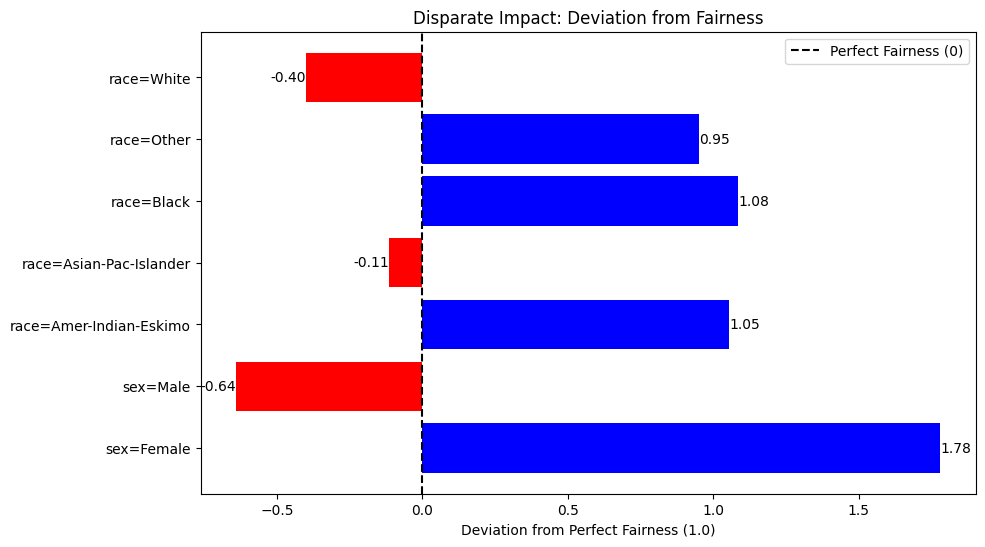

In [16]:
groups = [f"{item2}" for item1, item2 in list(di[{'income': 1}].keys())]
values = list(di[{'income': 1}].values())

deviation_from_fairness = np.array(values) - 1

plt.figure(figsize=(10, 6))
bars = plt.barh(groups, deviation_from_fairness, color=np.where(deviation_from_fairness > 0, 'blue', 'red'))

plt.axvline(x=0, color='black', linestyle='--', label='Perfect Fairness (0)')

plt.xlabel('Deviation from Perfect Fairness (1.0)')
plt.title('Disparate Impact: Deviation from Fairness')
plt.legend()

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', ha='left' if width > 0 else 'right', va='center')

plt.show()

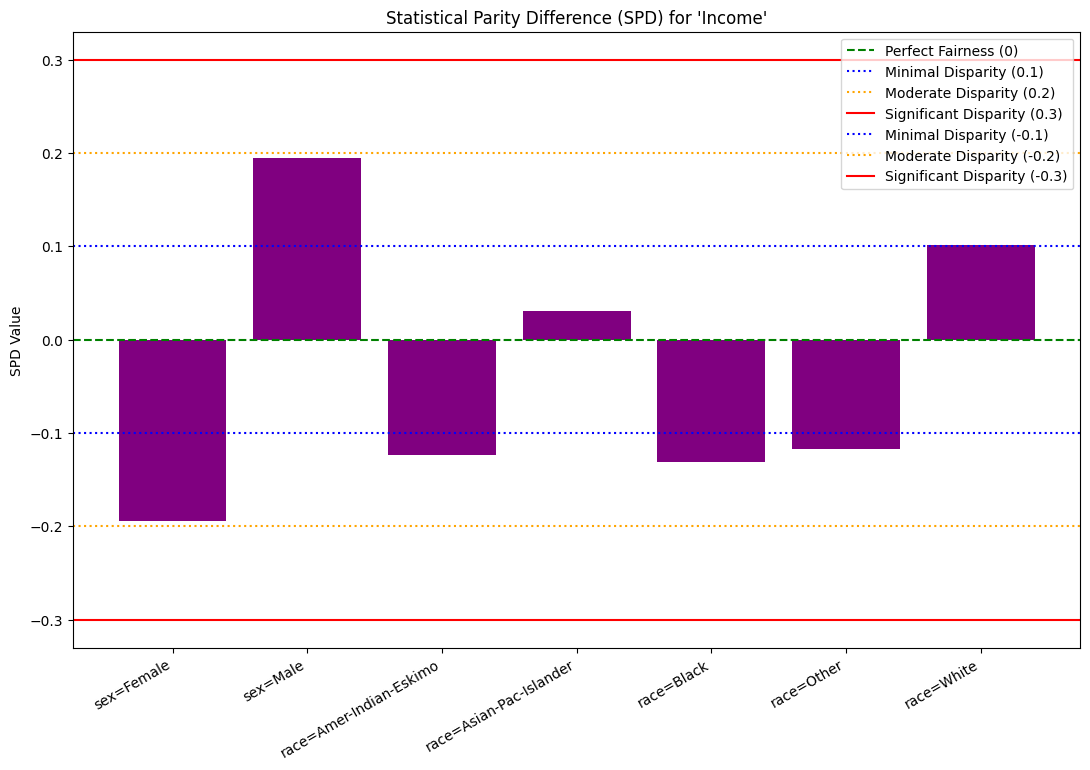

In [17]:
labels = [f"{item2}" for item1, item2 in list(spd[{'income': 1}].keys())]
values = list(spd[{'income': 1}].values())

groups = [f"{item2}" for item1, item2 in list(spd[{'income': 1}].keys())]
values = list(spd[{'income': 1}].values())

plt.figure(figsize=(13, 8))
bars_spd = plt.bar(groups, values, color='purple')

plt.axhline(y=0, color='green', linestyle='--', label='Perfect Fairness (0)')
plt.axhline(y=0.1, color='blue', linestyle=':', label='Minimal Disparity (0.1)')
plt.axhline(y=0.2, color='orange', linestyle=':', label='Moderate Disparity (0.2)')
plt.axhline(y=0.3, color='red', linestyle='-', label='Significant Disparity (0.3)')
plt.axhline(y=-0.1, color='blue', linestyle=':', label='Minimal Disparity (-0.1)')
plt.axhline(y=-0.2, color='orange', linestyle=':', label='Moderate Disparity (-0.2)')
plt.axhline(y=-0.3, color='red', linestyle='-', label='Significant Disparity (-0.3)')

plt.ylabel('SPD Value')
plt.title("Statistical Parity Difference (SPD) for 'Income'")
plt.xticks(rotation=30, ha='right')
plt.legend()

plt.show()

## 3.2 Proxy Indentification

Try different strategies to spot **proxy** features in the dataset:
* Correlation matrix
* Functional dependencies
* ...


# 4. Evaluation Protocol

We have to agree on a set of supported protocols:
* hold-out (train/test split)
* k-fold cross-validation (k splits)
* stratified k-fold cross-validation (each split has the same target distribution)
* stratified k-fold cross-validation for fairness (each split has also the same distribution wrt. sensitive features)

# 5. ML Pipeline Definition

ML pipeline "sklearn-like" with "fit_predict"

$$\frac{1}{k} \sum_{i=1}^{k} \mathcal{L}\left(\langle \mathcal{P}, \mathcal{A} \rangle_{\lambda} ( \mathcal{D}_{\mathit{train}}^{(i)}), \mathcal{D}_\mathit{valid}^{(i)} \right) \, .$$


## 5.1 Pre-processing

## 5.2 In-processing

## 5.3 Post-processing

# 6. Optimization

Find best pipelines in a multi-objective problem (i.e., provide a pareto front, pipelines are hyperparamter configurations that achieves the best trade-offs accuracy/fairness)